# Reconstruction of a positive-real wavefunction

In this tutorial, a walkthrough of how to reconstruct a **positive-real** wavefunction via training a *Restricted Boltzmann Machine* (RBM), the neural network behind qucumber, will be presented. After the training process, this tutorial will also demonstrate how new data can be generated and how observables can be calculated from the reconstructed wavefunction.

## Transverse field Ising model
Our example dataset, located in *tfim1d_train_samples.txt*, comprises of 10,000 $\sigma^{z}$ measurements from a one-dimensional transverse-field Ising model (TFIM) with 10 sites at its critical point. The Hamiltonian for the transverse-field Ising model (TFIM) is given by

\begin{equation}
	\mathcal{H} = -J\sum_i \sigma^z_i \sigma^z_{i+1} - h \sum_i
\sigma^x_i
\end{equation}

where $\sigma^{z}_i$ is the conventional spin-1/2 Pauli operator on site $i$. At the critical point, $J=h=1$. As per convention, spins are represented in binary notation with zero and one denoting spin-down and spin-up, respectively.

## Using qucumber 

### Imports
To begin the tutorial, we first import the required Python packages.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from qucumber.nn_states import PositiveWavefunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data

import quantum_ising_chain
from quantum_ising_chain import TFIMChainEnergy, TFIMChainMagnetization

The Python class *PositiveWavefunction* contains generic properties of a RBM meant to reconstruct a positive-real wavefunction, the most notable one being the gradient function required for stochastic gradient descent.

To instantiate a *PositiveWavefunction* object, one needs to specify the number of visible and hidden units in the RBM. The number of visible units, *num_visible*, is given by the size of the physical system, i.e. the number of spins or qubits (10 in our case), while the number of hidden units, *num_hidden*, can be varied to change the expressiveness of the neural network.

**Note:** The optimal *num_hidden* : *num_visible* ratio will depend on the system. For the TFIM, having this ratio be equal to 1 leads to good results with reasonable computational effort.

The *MetricEvaluator* class and *training_statistics* utility are built-in amenities that will allow the user to evaluate the training in real time. 

Lastly, *quantum_ising_chain* is a user-made file that will be used after the wavefunction has been reconstructed in order to generate new data and compute the magnetization and energy of those new samples.

### Training
To evaluate the training in real time, the fidelity between the true ground-state wavefunction of the system and the wavefunction that qucumber reconstructs, $\vert\langle\psi\vert\psi_{RBM}\rangle\vert^2$, will be calculated along with the Kullback-Leibler (KL) divergence (the RBM's cost function). First, we need to load our training data and the true wavefunction of this system using the *data* utility.

In [2]:
psi_path   = "tfim1d_psi.txt"
train_path = "tfim1d_train.txt"
train_samples, true_psi = data.load_data(train_path, psi_path)

As previously mentioned, to instantiate a *PositiveWavefunction* object, one needs to specify the number of visible and hidden units in the RBM. We will keep these two quantities equal.

In [3]:
nv = train_samples.shape[-1]
nh = nv

nn_state = PositiveWavefunction(num_visible=nv, num_hidden=nh)
#nn_state = PositiveWavefunction(num_visible=nv, num_hidden=nh, gpu = False)

By default, qucumber will attempt to run on a GPU if one is available (if one is not available, qucumber will default to CPU). If one wishes to run qucumber on a CPU, add the flag "gpu = False" in the *PositiveWavefunction* object instantiation (i.e. uncomment the line above). 

Now we can specify the hyperparameters of the training process. 

1. **epochs**: the total number of training cycles that will be performed (default = 100)
2. **pos_batch_size**: the number of data points used in the positive phase of the gradient (default = 100)
3. **neg_batch_size**: the number of data points used in the negative phase of the gradient (default = *pos_batch_size*)
4. **k**: the number of contrastive divergence steps (default = 1)
5. **lr**: the learning rate (default = 0.001)

    **Note:** For more information on the hyperparameters above, we strongly encourage the user to read through our brief, but thorough theory document on RBMs. One does not have to specify these hyperparameters, as their default values will be used without the user overwriting them. It is recommended to keep with the default values until the user has a stronger grasp on what these hyperparameters mean. The quality and the computational efficiency of the training will highly depend on the choice of hyperparameters. As such, playing around with the hyperparameters is almost always necessary. 
    
We have found that for the TFIM with 10 sites, the following hyperparameters give excellent results.

In [4]:
epochs = 1000
pbs    = 100 # pos_batch_size
nbs    = 200 # neg_batch_size
lr     = 0.01
k      = 10

For evaluating the training in real time, we will call on the *MetricEvaluator* to calculate the training evaluators every 100 epochs. The *MetricEvaluator* requires the following arguments.

1. **log_every**: the frequency of the training evaluators being calculated is controlled by the *log_every* argument (e.g. *log_every* = 200 means that the *MetricEvaluator* will update the user every 200 epochs)
2. A dictionary of functions you would like to reference to evaluate the training (arguments required for these functions are keyword arguments placed after the dictionary)

The following additional arguments are needed to calculate the fidelity and KL divergence in the *training_statistics* utility.

- **target_psi** (the true wavefunction of the system)
- **verbose** (a boolean for telling the *MetricEvaluator* to print the training evaluators)
- **space** (the hilbert space of the system)

In [5]:
log_every      = 100
nn_state.space = nn_state.generate_hilbert_space(nv)

callbacks = [
    MetricEvaluator(log_every, {"Fidelity": ts.fidelity, "KL": ts.KL}, target_psi=true_psi, verbose=True, 
                    space=nn_state.space)
]

Now we can begin training. The *PositiveWavefunction* object has a property called *fit* which takes care of this for us.

In [6]:
nn_state.fit(train_samples, epochs=epochs, pos_batch_size=pbs, neg_batch_size=nbs, lr=lr, k=k, callbacks=callbacks)
#nn_state.fit(train_samples, callbacks=callbacks)

Epoch: 100	Fidelity = 0.920500	KL = 0.164668
Epoch: 200	Fidelity = 0.965034	KL = 0.068971
Epoch: 300	Fidelity = 0.980916	KL = 0.037920
Epoch: 400	Fidelity = 0.986665	KL = 0.026769
Epoch: 500	Fidelity = 0.988956	KL = 0.022347
Epoch: 600	Fidelity = 0.989727	KL = 0.020779
Epoch: 700	Fidelity = 0.991288	KL = 0.017595
Epoch: 800	Fidelity = 0.992437	KL = 0.015200
Epoch: 900	Fidelity = 0.993383	KL = 0.013235
Epoch: 1000	Fidelity = 0.994390	KL = 0.011251


It should be noted that all the code past the third code block of this notebook is not needed for the training process. One could have just ran *nn_state.fit(train_samples)* and just used the default hyperparameters and no training evaluators.

To demonstrate how important it is to find the optimal hyperparameters for a certain system, restart this notebook and uncomment the line above and comment out the original *fit* statement. The default hyperparameters will be used instead. Using the non-default hyperparameters yielded a fidelity of approximately 0.994, while the default hyperparameters yielded a fidelity of approximately 0.523!

### Post-training
#### Saving and loading parameters

At the end of the training process, the network parameters (the weights, visible biases and hidden biases) are stored in the *PositiveWavefunction* object. One can save them to a pickle file, which will be called *saved_params*, with the following command.

In [7]:
nn_state.save("saved_params.pt")

This saves the weights, visible biases and hidden biases as torch tensors with the following keys: "weights", "visible_bias", "hidden_bias". One can then load a new *PositiveWavefunction* object with saved parameters with the following command.

In [8]:
nn_state2 = PositiveWavefunction.autoload("saved_params.pt")

#### Generate new data

At the end of the training process, the user can then generate new data. A PositiveWavefunction object has a property called *sample* that takes in the following arguments.

1. **k**: the number of Gibbs steps to perform to generate the new samples
2. **num_samples**: the number of new data points to be generated

In [9]:
new_samples = nn_state.sample(k=10, num_samples=100)

This new data can also be saved (along with the RBM parameters) with the following command.

In [10]:
nn_state.save("saved_params_and_new_data.pt", metadata={"samples":new_samples})

*metadata* is a disctionary that is an optional argument in the *PositiveWavefunction*'s *save* function.

#### Calculate observables

Some observables cannot be computed directly from samples, but instead depend on the RBM. For this purpose, qucumber has the *observables* module to compute any arbitrary observable from the RBM. An example for the computation of the energy and magnetization is provided in the python file *quantum_ising_chain.py*, which takes advantage of qucumber's *observables* module.

*quantum_ising_chain* comprises of two classes: one to calculate the energy of a TFIM (*TFIMChainEnergy*) and one to calculate the magnetization of a TFIM (*TFIMChainMagnetization*). The following arguments are required to instantiate those objects.

1. **h**: this is the h/J value of the TFIM (1 in the case of our dataset). This is only needed in *TFIMChainEnergy*.
2. **num_samples**: the number of samples to be generated from the trained RBM. These samples will be used to calculate the observables.

In [11]:
h = 1
num_samples = 10000

tfim_energy = TFIMChainEnergy(h, num_samples)
tfim_mag    = TFIMChainMagnetization(num_samples)

To go ahead and calculate the energy and magnetization along with their respective standard errors, we call the  *statistics* function in the *observables* module, which requires the neural network state (in this case the *PositiveWavefunction* object) and the number of samples that are to be generated (the samples are generated within the *observables* module; there is no need to call *nn_state.sample()*).

In [12]:
energy_stats = tfim_energy.statistics(nn_state, num_samples)
mag_stats    = tfim_mag.statistics(nn_state, num_samples)

print("Mean energy:  %.6f" % energy_stats["mean"], " +/- %.6f" % energy_stats["std_error"])
print("Mean magnetization: %.6f" % mag_stats["mean"], " +/- %.6f" % mag_stats["std_error"])

Mean energy:  -1.234837  +/- 0.000488
Mean magnetization: 0.548720  +/- 0.003123


The exact value for the energy is -1.2381, and for the magnetization is 0.5610. To illustrate how quickly the energy and magnetization converge as a function of the sampling step (i.e. the number of Gibbs steps to perform to generate the new batch of samples), *n_eq*, the code below will do the trick.

In [13]:
n_eq = 200
dict_observables = quantum_ising_chain.Convergence(nn_state, tfim_energy, tfim_mag, num_samples, n_eq)

energy     = dict_observables["energy"]["energies"]
err_energy = dict_observables["energy"]["error"]

mag     = dict_observables["sigmaZ"]["sZ"]
err_mag = dict_observables["sigmaZ"]["error"]

step = np.arange(n_eq + 1)

Text(0,0.5,'% Error in Magnetization')

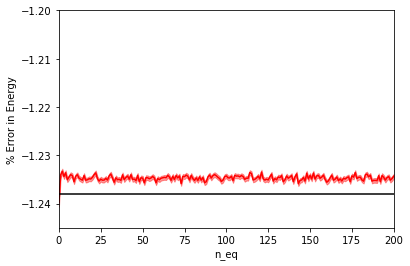

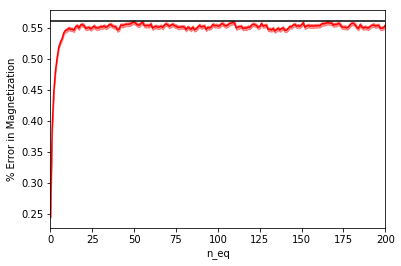

In [14]:
E0 = -1.2381
M0 = 0.561

plt.figure(1)
ax1 = plt.axes()
ax1.plot(step, energy, color='red')
ax1.axhline(E0, color="black")
ax1.set_xlim(0, n_eq)
ax1.set_ylim(-1.245, -1.20)
ax1.fill_between(step, energy+err_energy, energy-err_energy, alpha=0.4, color='red')
ax1.set_xlabel("n_eq")
ax1.set_ylabel("% Error in Energy")

plt.figure(2)
ax2 = plt.axes()
ax2.plot(step, mag, color='red')
ax2.set_xlim(0, n_eq)
ax2.axhline(M0, color="black")
ax2.fill_between(step, mag+err_mag, mag-err_mag, alpha=0.4, color='red')
ax2.set_xlabel("n_eq")
ax2.set_ylabel("% Error in Magnetization")

You can see a brief transient period in each observable, before the state of the
machine "warms up" to equilibrium.  After that, the values fluctuate around the
calculated mean.